# The horseshoe prior and its limitations 

*Gaëtan Ecrepont - Guillaume Martin-Festa*

Based on the Horseshoe paper by Carvalho et al. (2009), found [here](https://proceedings.mlr.press/v5/carvalho09a/carvalho09a.pdf).

## 1. Import libraries

In [ ]:
# numpyro for Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

# jax for numpy with GPU support
import jax.numpy as jnp
from jax import random

# visualization
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import numpy as np
from tqdm.notebook import tqdm

# prettier plots
sns.set_theme()

## 2. Priors on $\kappa_i$ induced by different priors on $\lambda_i$

In [ ]:
def plot_model_k(model, ax=None, color="blue"):
    """
    For a given model, plot the prior distribution of kappa. (there is a single kappa=kappa_0 since we set p=1 variables)
    """
    prior = Predictive(model, num_samples=1_000_000)
    prior_samples = prior(random.PRNGKey(0), p=1)
    lambda_i = prior_samples["lambdas"]
    k_i = 1/(1+lambda_i**2)
    model_name = model.__name__.split("_")[1]
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))
    ax.hist(k_i, bins=1000, density=True, histtype='step', color=color, label=model_name)
    ax.set_xlabel(r"$\kappa$")
    ax.set_ylabel(r"$p(\kappa)$")
    ax.set_ylim(0,5)
    ax.set_xlim(0,1)

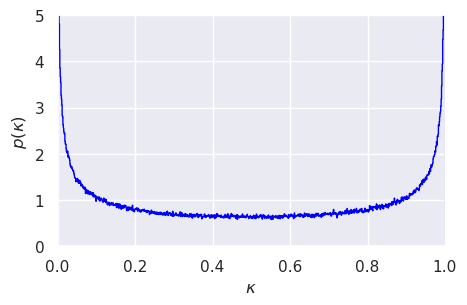

In [ ]:
def basic_horseshoe(p, y=None):
    """
    Classic horseshoe prior.
    """
    lambdas = numpyro.sample("lambdas", dist.HalfCauchy(jnp.ones(p)))
    tau = 1
    sigma = 1
    betas = numpyro.sample("betas", dist.Normal(0, lambdas*tau))
    y = numpyro.sample("y", dist.Normal(betas, sigma), obs=y)

plot_model_k(basic_horseshoe)

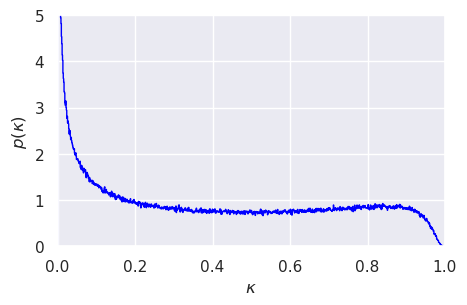

In [10]:
def basic_student(p, y=None):
    """
    Like horseshoe but using Inverse-Gamma priors on the lambda_i, thus yielding a Student prior on beta.
    """
    lambdas2 = numpyro.sample("lambdas", dist.InverseGamma(jnp.ones(p), jnp.ones(p)))
    lambdas = jnp.sqrt(lambdas2)

    tau = 1
    sigma = 1

    betas = numpyro.sample("betas", dist.Normal(0, lambdas*tau))
    y = numpyro.sample("y", dist.Normal(betas, sigma), obs=y)

plot_model_k(basic_student)

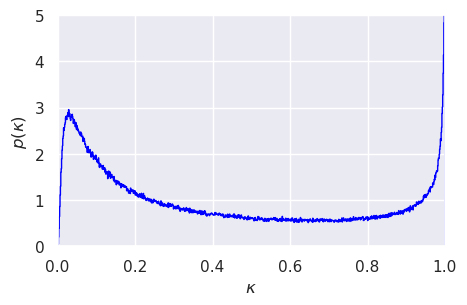

In [11]:
def basic_laplace(p, y=None):
    """
    Like horseshoe but using Exponential priors on the lambda_i, thus yielding a Laplace prior on beta.
    """
    lambdas2 = numpyro.sample("lambdas", dist.Exponential(rate=0.5*jnp.ones(p)))
    lambdas = jnp.sqrt(lambdas2)

    tau = 1
    sigma = 1

    betas = numpyro.sample("betas", dist.Normal(0, lambdas*tau))
    y = numpyro.sample("y", dist.Normal(betas, sigma), obs=y)

plot_model_k(basic_laplace)

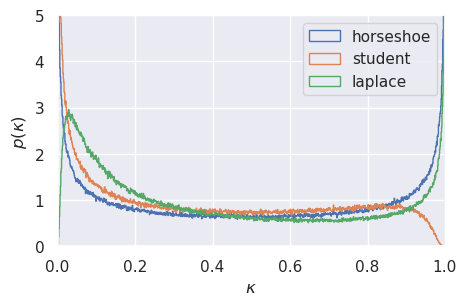

In [ ]:
# superimpose all three models
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(figsize=(5, 3))
for i, model in enumerate([basic_horseshoe, basic_student, basic_laplace]):
    plot_model_k(model, ax, COLORS[i])
plt.legend()
plt.show()

## 2. Prior on $\beta$ induced by different priors on $\lambda_i$

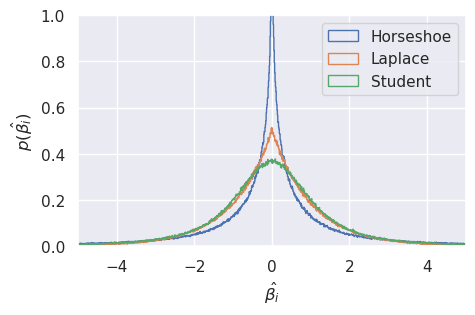

In [13]:
def plot_prior(model, ax, xlim=5):
    prior = Predictive(model, num_samples=1_000_000)
    prior_samples = prior(random.PRNGKey(0), p=1)
    beta = prior_samples["betas"]
    beta = beta[abs(beta)<xlim]
    model_name = model.__name__.split('_')[1].capitalize()
    ax.hist(beta, density=True, bins=1000, histtype="step", label=model_name)
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(0,1)

fig, ax = plt.subplots(figsize=(5,3))
for i, model in enumerate([basic_horseshoe, basic_laplace, basic_student]):
    plot_prior(model, ax)
plt.xlabel(r"$\hat{\beta_i}$")
plt.ylabel(r"$p(\hat{\beta_i})$")
plt.legend()
plt.show()

## 3. Posterior mean $\mathbb{E}[\beta_i | y]$ for various $y$, under horseshoe & Laplace priors on $\beta_i$

### 3.A Use MCMC to sample from the posterior distribution $p(\beta_i | y)$

In [ ]:
def simple_hs(y=None):
    # simplified horseshoe prior with tau=1 and sigma=1
    lmbda = numpyro.sample("lmbda", dist.HalfCauchy(1.0))
    beta = numpyro.sample("beta", dist.Normal(0,lmbda))
    y = numpyro.sample("y", dist.Normal(beta,1), obs=y)

mcmc_hs = MCMC(NUTS(simple_hs), num_warmup=1000, num_samples=5000, num_chains=1, progress_bar=False)
# note that we don't need to do MCMC to estimate the posterior mean of beta given y_i in the Laplace ase because we know in this simplified setting that it is a soft thresholding of y_i

y_s = jnp.linspace(-10, 10, 100) # all the y_i we observe
mean_hs = np.zeros_like(y_s) # mean of beta given y_i
for i, y in enumerate(tqdm(y_s)):
    mcmc_hs.run(random.PRNGKey(1), y=y)
    beta_samples_hs = mcmc_hs.get_samples()["beta"]
    mean_hs[i] = beta_samples_hs.mean()

  0%|          | 0/100 [00:00<?, ?it/s]

### 3.B Posterior mean $\mathbb{E}[\beta_i | y]$ for various $y$ (Horseshoe vs. Laplace)

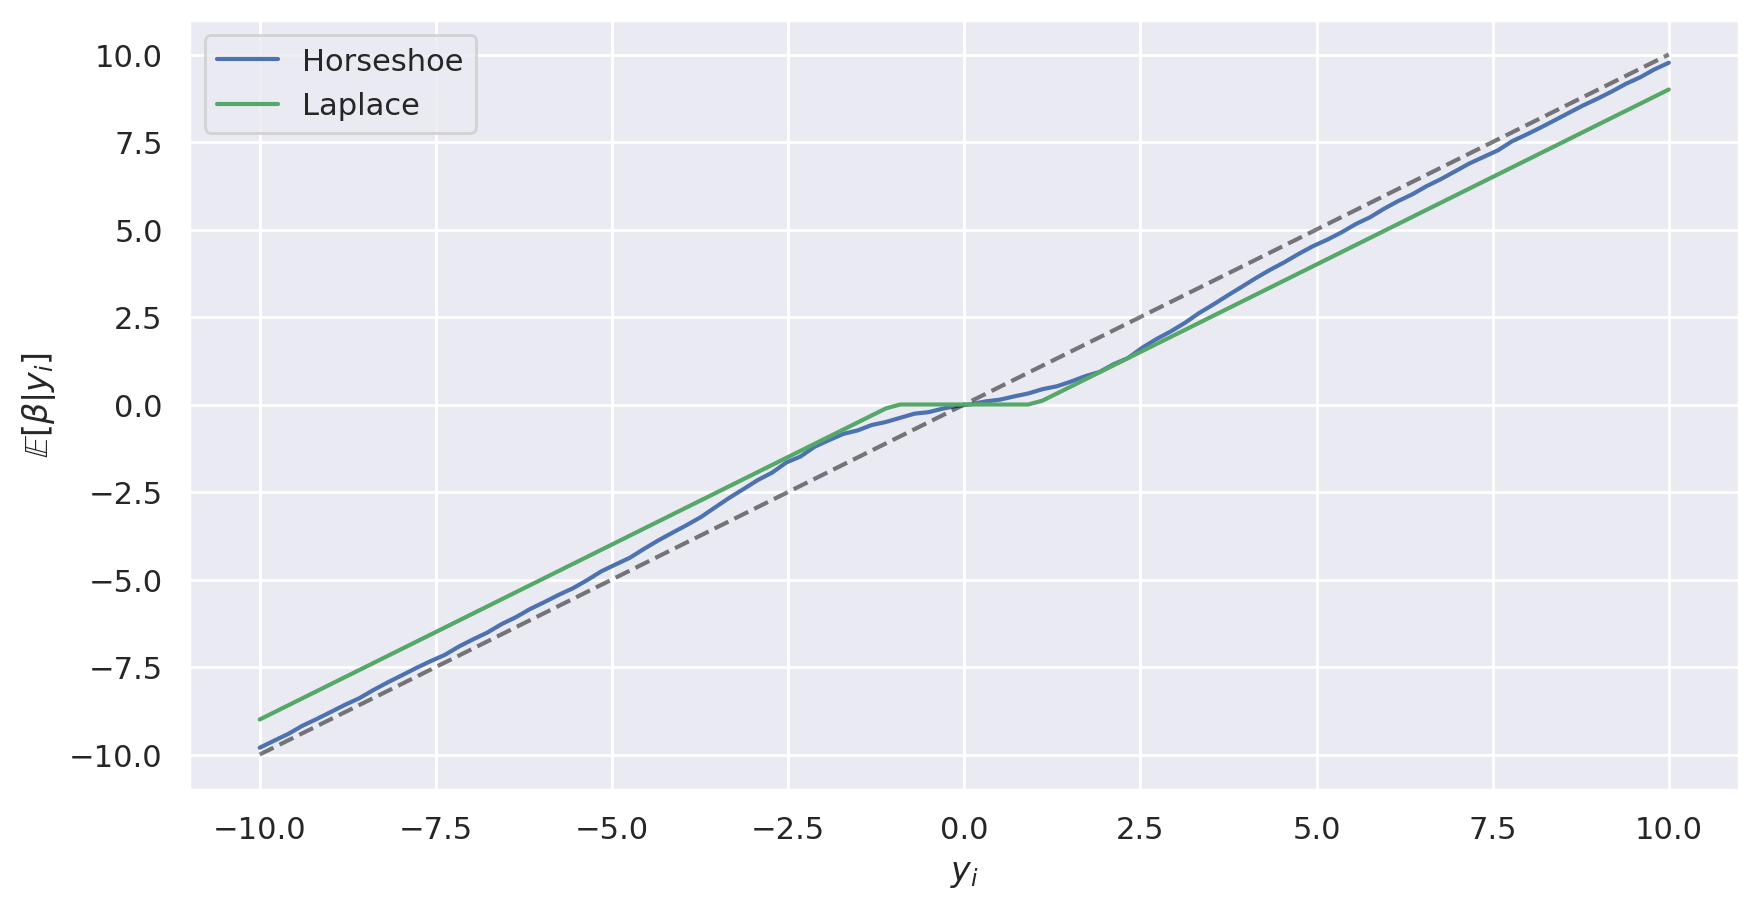

In [15]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(y_s, mean_hs, label="Horseshoe", color=COLORS[0])
laplace_th = np.sign(y_s) * np.maximum(np.abs(y_s)-1, 0)
plt.plot(y_s, y_s, c="black", alpha=0.5, ls='--')
plt.plot(y_s, laplace_th, label="Laplace", color=COLORS[2])
plt.xlabel(r"$y_i$")
plt.ylabel(r"$\mathbb{E}[\beta|y_i]$")
plt.legend()
plt.show()

## 4. Priors on $m_{eff}$ induced by different priors on $\tau$

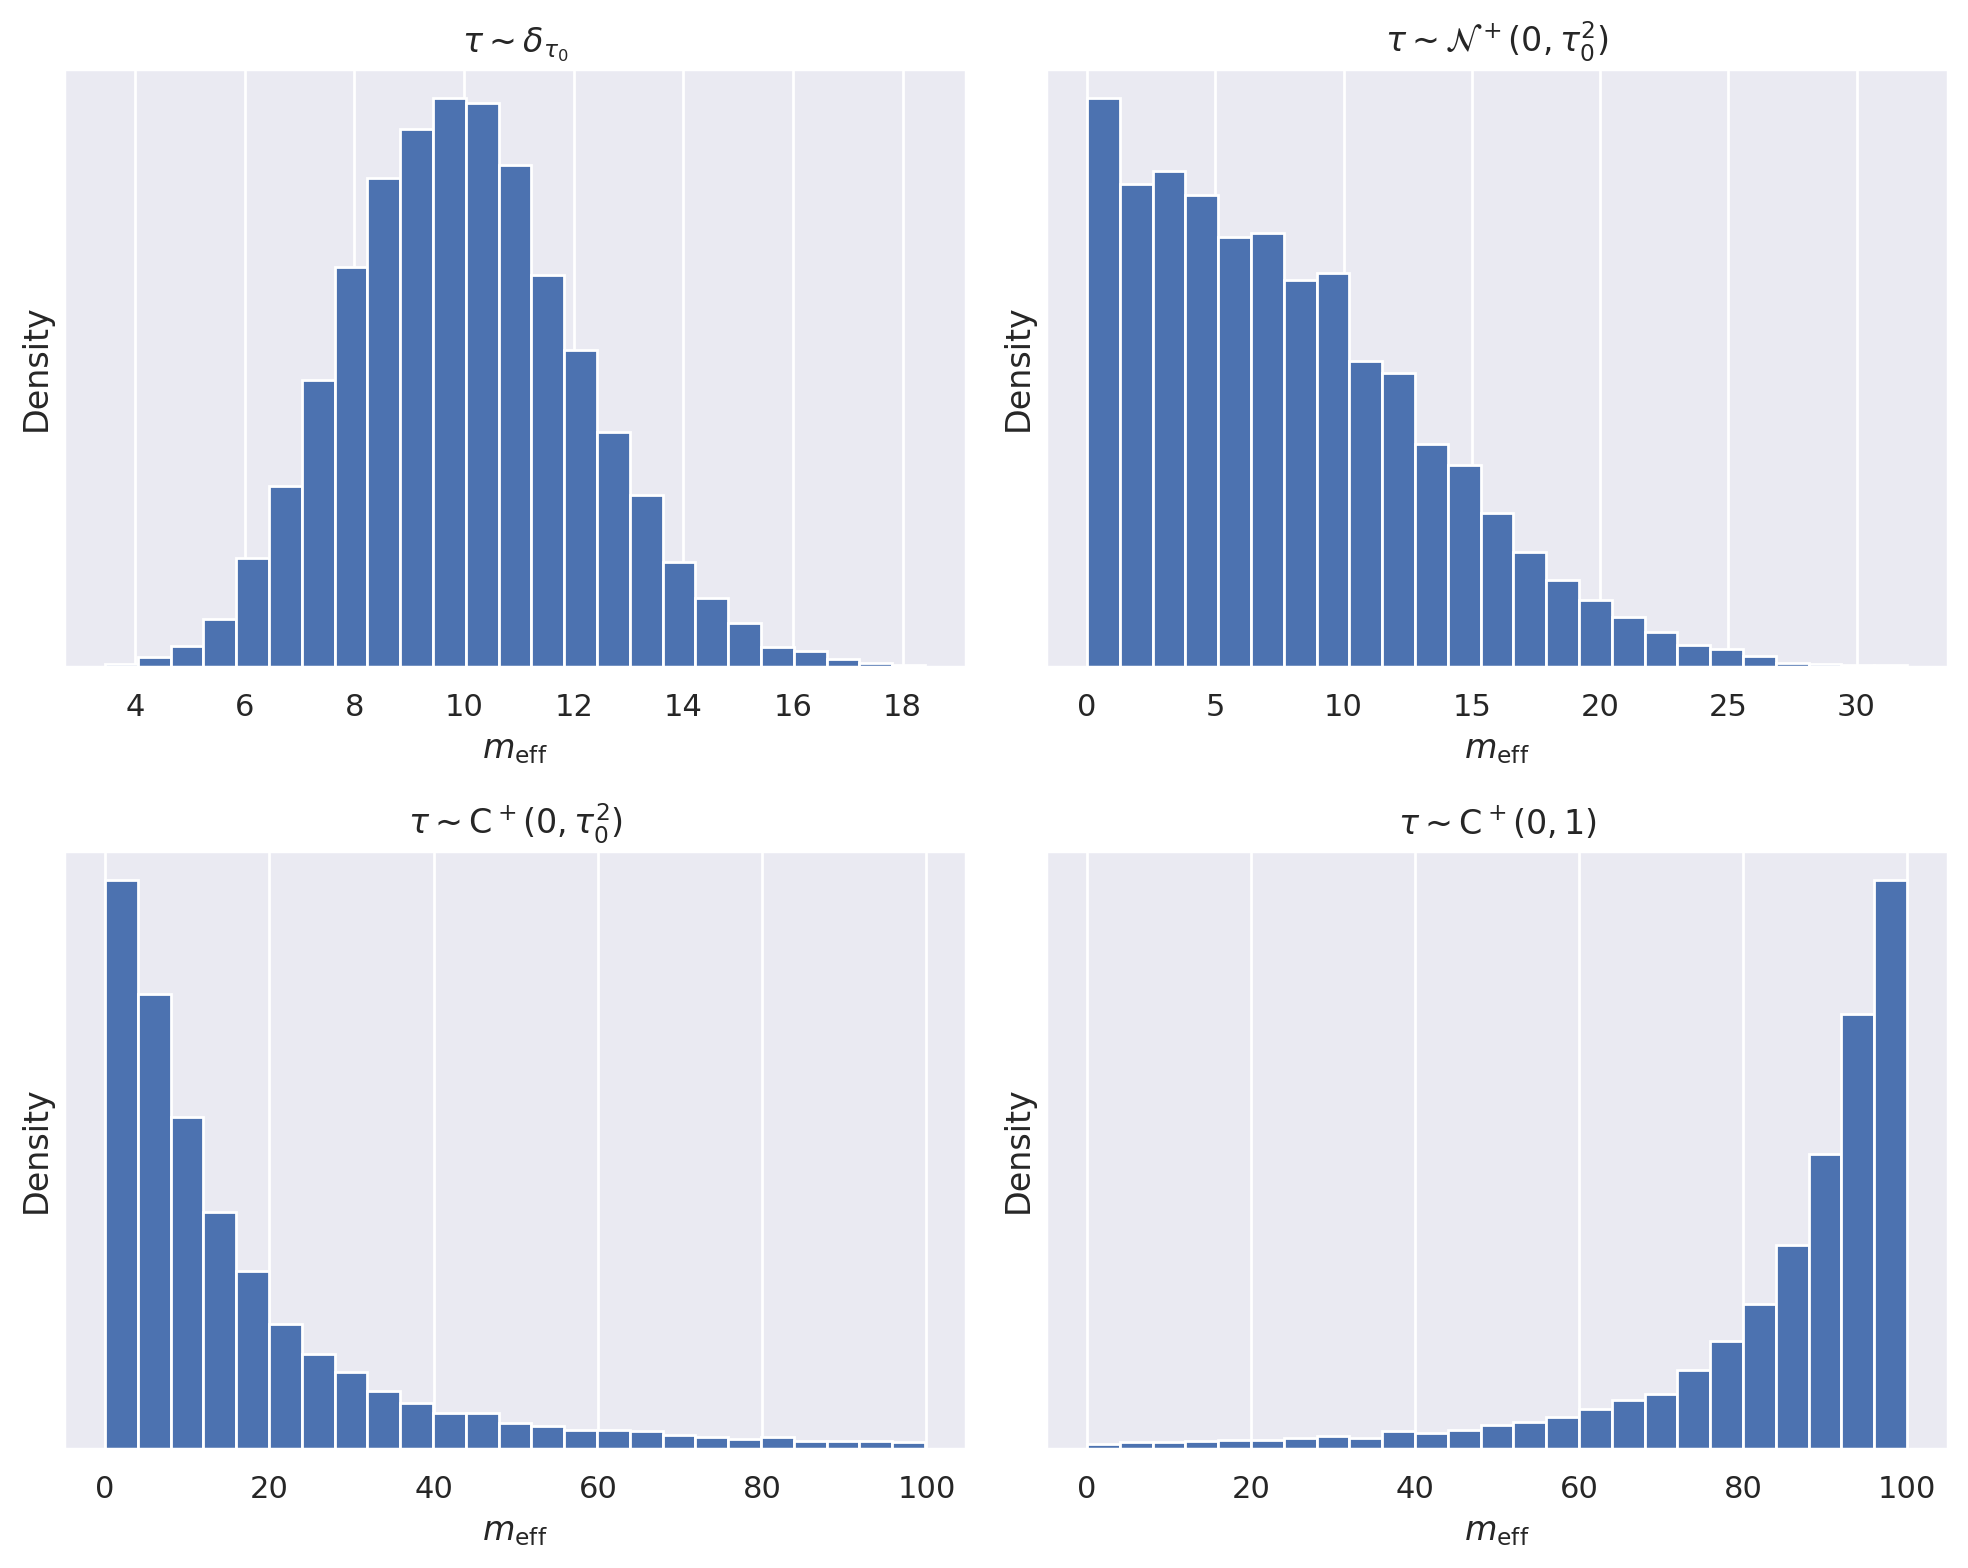

In [16]:
def model(p, dist_tau, y=None, sigma=1, n=100):
    """
    Horseshoe prior with a general tau distribution dist_tau. We also compute the effective number of parameters m_eff.
    """
    lambdas = numpyro.sample("lambdas", dist.HalfCauchy(jnp.ones(p)))
    tau = numpyro.sample("tau", dist_tau)
    betas = numpyro.sample("betas", dist.Normal(0, lambdas*tau))
    y = numpyro.sample("y", dist.Normal(betas, sigma), obs=y)

    kappa_i = 1/(1+n*sigma**-2*tau**2*lambdas**2)
    m_eff = numpyro.deterministic("m_eff", jnp.sum(1-kappa_i))


# reusing the values from the paper Sparsity information and regularization in the horseshoe and other shrinkage priors (https://arxiv.org/abs/1707.01694)
sigma = 1
n = 100
p0_hat = 10
p = 100 # dim
tau0 = sigma / n**.5 * p0_hat / (p - p0_hat) # heuristic choice of tau0
dist_taus = [dist.Normal(tau0, 0), dist.HalfNormal(tau0), dist.HalfCauchy(tau0), dist.HalfCauchy(1.0)] # all the priors on tau we want to test
dist_str = [r"$\tau\sim \delta_{\tau_0}$", r"$\tau\sim \mathcal{N}^+(0,\tau_0^2)$", r"$\tau\sim \text{C}^+(0,\tau_0^2)$", r"$\tau\sim \text{C}^+(0,1)$"]
fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=200)
idx = np.ndindex(2, 2)

for i, dist_tau in enumerate(dist_taus):
    prior = Predictive(model, num_samples=10_000)
    rng_key = random.PRNGKey(0)
    prior_samples = prior(rng_key, p=p, dist_tau=dist_tau)
    m_eff = prior_samples["m_eff"]
    ax = axs[next(idx)]
    ax.hist(m_eff, bins=25, density=True)
    ax.set_xlabel(r"$m_\text{eff}$")
    ax.set_label("Density")
    ax.set_yticks([])
    ax.set_ylabel("Density")
    ax.set_title(dist_str[i])
plt.tight_layout()
plt.show()